# Ad Detection Pipeline Using Fine-Tuned Sentence Transformer and Logistic Regression (Also Before)

In [2]:
pip install numpy pandas sentence_transformers scikit-learn 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 225.2 kB/s eta 0:00:000:01
  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached sentence_transformers-3.4.1-py3-none-any.whl.metadata (10 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached pytz-2025.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
  Using cached torch-2.6.0-cp312-cp312-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached scipy-1.15.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached huggingface_hub-0.29.3-py3-none-any.whl.metadata (13 kB)
  Using cached pillow-11.1.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threa

In [3]:
pip install datasets

  Using cached pyarrow-19.0.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached frozenlist-1.5.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached propcache-0.3.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached yarl-1.18.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (69 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4

In [2]:
pip install transformers[torch]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 2.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade sentence-transformers


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [1]:
from sentence_transformers import losses
print(losses.BinaryClassificationLoss)


/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: module 'sentence_transformers.losses' has no attribute 'BinaryClassificationLoss'

In [3]:
import json
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Custom transformer to wrap a Sentence Transformer model
class SentenceTransformerVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Generate sentence embeddings
        embeddings = self.model.encode(X, batch_size=32, show_progress_bar=True)
        return embeddings

def load_dataset(responses_file, labels_file):
    """
    Load dataset by reading responses and labels from JSONL files and merging them.
    """
    # Load responses into a dictionary mapping id -> response text
    responses = {}
    with open(responses_file, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            responses[data["id"]] = data["response"]
    
    # Load labels and merge with responses
    ids, texts, labels = [], [], []
    with open(labels_file, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            instance_id = data["id"]
            if instance_id in responses:
                ids.append(instance_id)
                texts.append(responses[instance_id])
                labels.append(data["label"])
    
    return ids, texts, labels

# File paths (update these paths as needed)
train_responses_file = '/root/Ad-Detection/Dataset/responses-train.jsonl'
train_labels_file = '/root/Ad-Detection/Dataset/responses-train-labels.jsonl'
val_responses_file   = '/root/Ad-Detection/Dataset/responses-validation.jsonl'
val_labels_file      = '/root/Ad-Detection/Dataset/responses-validation-labels.jsonl'
test_responses_file  = '/root/Ad-Detection/Dataset/responses-test.jsonl'
test_labels_file     = '/root/Ad-Detection/Dataset/responses-test-labels.jsonl'

# Load train and validation datasets separately
train_ids, train_texts, train_labels = load_dataset(train_responses_file, train_labels_file)
val_ids, val_texts, val_labels = load_dataset(val_responses_file, val_labels_file)

# Combine train and validation sets into one training set
combined_ids = train_ids + val_ids
combined_texts = train_texts + val_texts
combined_labels = train_labels + val_labels

# Load test dataset
test_ids, test_texts, test_labels = load_dataset(test_responses_file, test_labels_file)

# -----------------------------------------------------
# Experiment: Logistic Regression with Sentence Transformer Embeddings for Advertisement Detection
# Classifier: Logistic Regression (predicts label 1 as advertisement)
# Feature Extraction: Sentence Transformer to generate embeddings
# Goal: Evaluate performance specifically for detecting advertisements (label 1)
# -----------------------------------------------------

# Build the pipeline: Sentence Transformer vectorizer + Logistic Regression
pipeline = make_pipeline(
    SentenceTransformerVectorizer(model_name='all-MiniLM-L6-v2'),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)

# -------------------------
# Cross-Validation on Combined Training Set
# -------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Use scoring 'f1' which, for binary classification, computes the F1 score for the positive class (label 1)
cv_scores = cross_val_score(pipeline, combined_texts, combined_labels, cv=cv, scoring='f1')
print("Cross-validation F1 Score (for ad detection, label=1) on Combined Training Set:", cv_scores)
print("Mean Cross-validation F1 Score:", np.mean(cv_scores))

# -------------------------
# Train the Model on the Full Combined Training Set
# -------------------------
pipeline.fit(combined_texts, combined_labels)

# -------------------------
# Evaluation on Combined Training Set
# -------------------------
train_preds = pipeline.predict(combined_texts)
train_report_dict = classification_report(combined_labels, train_preds, output_dict=True)
train_cm = confusion_matrix(combined_labels, train_preds)
# Save training evaluation to CSV
df_train_report = pd.DataFrame(train_report_dict).transpose()
df_train_report.to_csv('/root/Ad-Detection/csv-result/train_classification_report.csv', index=True)

df_train_cm = pd.DataFrame(train_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
df_train_cm.to_csv('/root/Ad-Detection/csv-result/train_confusion_matrix.csv', index=True)

print("\nCombined Training Set Evaluation:")
print(classification_report(combined_labels, train_preds))
print("Confusion Matrix (Combined Training):")
print(confusion_matrix(combined_labels, train_preds))
# Calculate F1 Score for label 1 explicitly:
print("F1 Score for ads (label 1):", f1_score(combined_labels, train_preds, pos_label=1))

# -------------------------
# Evaluation on Test Set
# -------------------------
test_preds = pipeline.predict(test_texts)
test_report_dict = classification_report(test_labels, test_preds, output_dict=True)
test_cm = confusion_matrix(test_labels, test_preds)

# Save test evaluation to CSV
df_test_report = pd.DataFrame(test_report_dict).transpose()
df_test_report.to_csv('/root/Ad-Detection/csv-result/test_classification_report.csv', index=True)

df_test_cm = pd.DataFrame(test_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
df_test_cm.to_csv('/root/Ad-Detection/csv-result/test_confusion_matrix.csv', index=True)

print("\nTest Set Evaluation:")
print(classification_report(test_labels, test_preds))
cm = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix (Test):")
print(cm)
print("F1 Score for ads (label 1):", f1_score(test_labels, test_preds, pos_label=1))

# Calculate additional metrics for label 1 based on the confusion matrix
TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
detection_accuracy = TP / (TP + FN) if (TP + FN) > 0 else 0  # Recall for ads
false_negative_rate = FN / (TP + FN) if (TP + FN) > 0 else 0
false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0

print("Detection Accuracy for ads (label 1):", detection_accuracy)
print("False Negative Rate for ads (label 1):", false_negative_rate)
print("False Positive Rate for ads (label 1):", false_positive_rate)

# Additional snippet to calculate and print the F1 score for detecting ads (label 1)
f1_ads = f1_score(test_labels, test_preds, pos_label=1)
print("F1-score for detecting ads:", f1_ads)

# Calculate additional metrics for label 0 (non-ads) by treating label 0 as the positive class
detection_accuracy_non_ads = TN / (TN + FP) if (TN + FP) > 0 else 0  # Recall for non-ads
false_negative_rate_non_ads = FP / (TN + FP) if (TN + FP) > 0 else 0
false_positive_rate_non_ads = FN / (FN + TP) if (FN + TP) > 0 else 0

print("Detection Accuracy for non-ads (label 0):", detection_accuracy_non_ads)
print("False Negative Rate for non-ads (label 0):", false_negative_rate_non_ads)
print("False Positive Rate for non-ads (label 0):", false_positive_rate_non_ads)
f1_non_ads = f1_score(test_labels, test_preds, pos_label=0)
print("F1-score for non-detecting ads (label 0):", f1_non_ads)

# -------------------------
# Submission File Generation
# -------------------------
submission_file = '/root/Ad-Detection/Submission/logReg-baseline.jsonl'
with open(submission_file, 'w', encoding='utf-8') as f_out:
    for instance_id, pred in zip(test_ids, test_preds):
        result = {
            "id": instance_id,
            "label": int(pred),  # ensuring it's an integer (0 or 1)
            "tag": "myGroupMyMethod"
        }
        f_out.write(json.dumps(result) + "\n")
        
print(f"\nSubmission file saved to: {submission_file}")

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 93/93 [00:02<00:00, 41.11it/s]


Cross-validation F1 Score (for ad detection, label=1) on Combined Training Set: [0.58476027 0.59096665 0.5841714  0.58031088 0.57700651]
Mean Cross-validation F1 Score: 0.5834431437150649


Batches: 100%|██████████| 461/461 [00:11<00:00, 40.58it/s]



Combined Training Set Evaluation:
              precision    recall  f1-score   support

           0       0.81      0.69      0.74      9616
           1       0.54      0.69      0.61      5128

    accuracy                           0.69     14744
   macro avg       0.67      0.69      0.68     14744
weighted avg       0.72      0.69      0.70     14744

Confusion Matrix (Combined Training):
[[6639 2977]
 [1590 3538]]
F1 Score for ads (label 1): 0.6077471442068195


Batches: 100%|██████████| 82/82 [00:02<00:00, 40.01it/s]


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1687
           1       0.52      0.63      0.57       913

    accuracy                           0.67      2600
   macro avg       0.65      0.66      0.65      2600
weighted avg       0.69      0.67      0.67      2600

Confusion Matrix (Test):
[[1168  519]
 [ 341  572]]
F1 Score for ads (label 1): 0.5708582834331337
Detection Accuracy for ads (label 1): 0.6265060240963856
False Negative Rate for ads (label 1): 0.37349397590361444
False Positive Rate for ads (label 1): 0.3076467101363367
F1-score for detecting ads: 0.5708582834331337
Detection Accuracy for non-ads (label 0): 0.6923532898636633
False Negative Rate for non-ads (label 0): 0.3076467101363367
False Positive Rate for non-ads (label 0): 0.37349397590361444
F1-score for non-detecting ads (label 0): 0.7309136420525657

Submission file saved to: /root/Ad-Detection/Submission/logReg-baseline.jsonl


In [4]:
import json
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# ---------------------------------------
# Custom Binary Classification Loss
# ---------------------------------------
class CustomBinaryClassificationLoss(nn.Module):
    def __init__(self, model):
        super(CustomBinaryClassificationLoss, self).__init__()
        self.model = model
        # Create a linear layer to map embeddings to a single logit
        self.classifier = nn.Linear(model.get_sentence_embedding_dimension(), 1)
        self.loss_fct = nn.BCEWithLogitsLoss()
    
    def forward(self, sentence_features, labels):
        # sentence_features is typically a list of dicts (one per sentence).
        # We extract the first element which contains the tokenized features.
        features = sentence_features[0]
        # Get embeddings from the model using the features dictionary.
        embeddings = self.model(features)['sentence_embedding']
        # Compute logits from the embeddings
        logits = self.classifier(embeddings).view(-1)
        # Compute loss using BCEWithLogitsLoss (which applies sigmoid internally)
        loss = self.loss_fct(logits, labels.float())
        return loss

# ---------------------------------------
# 1. Data Loading Function
# ---------------------------------------
def load_dataset(responses_file, labels_file):
    """
    Load dataset by reading responses and labels from JSONL files and merging them.
    """
    responses = {}
    with open(responses_file, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            responses[data["id"]] = data["response"]
    
    ids, texts, labels = [], [], []
    with open(labels_file, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            instance_id = data["id"]
            if instance_id in responses:
                ids.append(instance_id)
                texts.append(responses[instance_id])
                labels.append(data["label"])
    
    return ids, texts, labels

# ---------------------------------------
# 2. File Paths (Update these paths as needed)
# ---------------------------------------
train_responses_file = '/root/Ad-Detection/Dataset/responses-train.jsonl'
train_labels_file    = '/root/Ad-Detection/Dataset/responses-train-labels.jsonl'
val_responses_file   = '/root/Ad-Detection/Dataset/responses-validation.jsonl'
val_labels_file      = '/root/Ad-Detection/Dataset/responses-validation-labels.jsonl'
test_responses_file  = '/root/Ad-Detection/Dataset/responses-test.jsonl'
test_labels_file     = '/root/Ad-Detection/Dataset/responses-test-labels.jsonl'

# ---------------------------------------
# 3. Load Datasets
# ---------------------------------------
train_ids, train_texts, train_labels = load_dataset(train_responses_file, train_labels_file)
val_ids, val_texts, val_labels = load_dataset(val_responses_file, val_labels_file)

combined_ids = train_ids + val_ids
combined_texts = train_texts + val_texts
combined_labels = train_labels + val_labels

test_ids, test_texts, test_labels = load_dataset(test_responses_file, test_labels_file)

# ---------------------------------------
# 4. Prepare Data for Fine-Tuning
# ---------------------------------------
train_examples = []
for text, label in zip(combined_texts, combined_labels):
    train_examples.append(InputExample(texts=[text], label=float(label)))

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

# ---------------------------------------
# 5. Fine-Tune the Sentence Transformer
# ---------------------------------------
model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

# Instantiate our custom binary classification loss.
train_loss = CustomBinaryClassificationLoss(model=model)

num_epochs = 3
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    output_path='/root/Ad-Detection/Fine-Tune-model/fine_tuned_all-MiniLM-L6-v2'
)

# ---------------------------------------
# 6. Extract Embeddings and Train a Classifier
# ---------------------------------------
train_embeddings = model.encode(combined_texts, batch_size=32, show_progress_bar=True)
test_embeddings  = model.encode(test_texts, batch_size=32, show_progress_bar=True)

clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
clf.fit(train_embeddings, combined_labels)

# ---------------------------------------
# 7. Evaluate the Classifier on the Test Set
# ---------------------------------------
test_preds = clf.predict(test_embeddings)
print("Test Set Evaluation:")
print(classification_report(test_labels, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_preds))
print("F1 Score for ads (label 1):", f1_score(test_labels, test_preds, pos_label=1))

cm = confusion_matrix(test_labels, test_preds)
TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
detection_accuracy = TP / (TP + FN) if (TP + FN) > 0 else 0
false_negative_rate = FN / (TP + FN) if (TP + FN) > 0 else 0
false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0

print("Detection Accuracy for ads (label 1):", detection_accuracy)
print("False Negative Rate for ads (label 1):", false_negative_rate)
print("False Positive Rate for ads (label 1):", false_positive_rate)

# ---------------------------------------
# 8. Generate Submission File (Optional)
# ---------------------------------------
submission_file = '/root/Ad-Detection/Submission/baseline-logReg.jsonl'
with open(submission_file, 'w', encoding='utf-8') as f_out:
    for instance_id, pred in zip(test_ids, test_preds):
        result = {
            "id": instance_id,
            "label": int(pred),
            "tag": "myGroupMyMethod"
        }
        f_out.write(json.dumps(result) + "\n")
print(f"\nSubmission file saved to: {submission_file}")


Step,Training Loss
500,0.587800
1000,0.468100
1500,0.458100
2000,0.454700
2500,0.451800


Batches: 100%|██████████| 82/82 [00:01<00:00, 41.12it/s]


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1687
           1       0.97      0.96      0.97       913

    accuracy                           0.98      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.98      0.98      0.98      2600

Confusion Matrix:
[[1661   26]
 [  36  877]]
F1 Score for ads (label 1): 0.9658590308370044
Detection Accuracy for ads (label 1): 0.9605695509309967
False Negative Rate for ads (label 1): 0.03943044906900329
False Positive Rate for ads (label 1): 0.015411973918197985

Submission file saved to: /root/Ad-Detection/Submission/baseline-logReg.jsonl


In [4]:
import json
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# ---------------------------------------
# 1. Utility Function to Load Dataset
# ---------------------------------------
def load_dataset(responses_file, labels_file):
    """
    Load dataset by reading responses and labels from JSONL files and merging them.
    """
    responses = {}
    with open(responses_file, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            responses[data["id"]] = data["response"]
    
    ids, texts, labels = [], [], []
    with open(labels_file, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            instance_id = data["id"]
            if instance_id in responses:
                ids.append(instance_id)
                texts.append(responses[instance_id])
                labels.append(data["label"])
    
    return ids, texts, labels

# ---------------------------------------
# 2. File Paths (Update these paths as needed)
# ---------------------------------------
train_responses_file = '/root/Ad-Detection/Dataset/responses-train.jsonl'
train_labels_file    = '/root/Ad-Detection/Dataset/responses-train-labels.jsonl'
val_responses_file   = '/root/Ad-Detection/Dataset/responses-validation.jsonl'
val_labels_file      = '/root/Ad-Detection/Dataset/responses-validation-labels.jsonl'
test_responses_file  = '/root/Ad-Detection/Dataset/responses-test.jsonl'
test_labels_file     = '/root/Ad-Detection/Dataset/responses-test-labels.jsonl'

# ---------------------------------------
# 3. Load Datasets and Combine Training Data
# ---------------------------------------
# Load training and validation sets and combine them for classifier training
train_ids, train_texts, train_labels = load_dataset(train_responses_file, train_labels_file)
val_ids, val_texts, val_labels = load_dataset(val_responses_file, val_labels_file)
combined_ids = train_ids + val_ids
combined_texts = train_texts + val_texts
combined_labels = train_labels + val_labels

# Load test set
test_ids, test_texts, test_labels = load_dataset(test_responses_file, test_labels_file)

# ---------------------------------------
# 4. Load the Fine-Tuned Sentence Transformer
# ---------------------------------------
model_path = '/root/Ad-Detection/Fine-Tune-model/fine_tuned_all-MiniLM-L6-v2'
model = SentenceTransformer(model_path)

# ---------------------------------------
# 5. Extract Embeddings
# ---------------------------------------
print("Extracting embeddings for training data...")
train_embeddings = model.encode(combined_texts, batch_size=32, show_progress_bar=True)
print("Extracting embeddings for test data...")
test_embeddings = model.encode(test_texts, batch_size=32, show_progress_bar=True)

# ---------------------------------------
# 6. Train Logistic Regression Classifier
# ---------------------------------------
clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
clf.fit(train_embeddings, combined_labels)

# ---------------------------------------
# 7. Evaluate the Classifier on the Test Set
# ---------------------------------------
test_preds = clf.predict(test_embeddings)
print("\nTest Set Evaluation:")
print(classification_report(test_labels, test_preds))
cm = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(cm)
print("F1 Score for ads (label 1):", f1_score(test_labels, test_preds, pos_label=1))

# Calculate additional metrics
if cm.shape == (2, 2):
    TN, FP, FN, TP = cm.ravel()
else:
    TN = FP = FN = TP = 0
detection_accuracy = TP / (TP + FN) if (TP + FN) > 0 else 0
false_negative_rate = FN / (TP + FN) if (TP + FN) > 0 else 0
false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0

print("Detection Accuracy for ads (label 1):", detection_accuracy)
print("False Negative Rate for ads (label 1):", false_negative_rate)
print("False Positive Rate for ads (label 1):", false_positive_rate)

# ---------------------------------------
# 8. Bootstrapping to Estimate Standard Deviations of Evaluation Metrics
# ---------------------------------------
n_iterations = 1000
metrics_boot = {"f1": [], "detection_accuracy": [], "false_negative_rate": [], "false_positive_rate": []}
n_test = len(test_labels)
test_labels_np = np.array(test_labels)
test_preds_np = np.array(test_preds)

for i in range(n_iterations):
    indices = np.random.choice(n_test, n_test, replace=True)
    y_true_boot = test_labels_np[indices]
    y_pred_boot = test_preds_np[indices]
    
    # Compute F1 Score (handle cases where one class might be missing)
    try:
        f1_b = f1_score(y_true_boot, y_pred_boot, pos_label=1)
    except Exception:
        f1_b = np.nan
    
    cm_b = confusion_matrix(y_true_boot, y_pred_boot, labels=[0, 1])
    if cm_b.shape == (2, 2):
        TN_b, FP_b, FN_b, TP_b = cm_b.ravel()
    else:
        TN_b = FP_b = FN_b = TP_b = 0
    detection_accuracy_b = TP_b / (TP_b + FN_b) if (TP_b + FN_b) > 0 else 0
    false_negative_rate_b = FN_b / (TP_b + FN_b) if (TP_b + FN_b) > 0 else 0
    false_positive_rate_b = FP_b / (FP_b + TN_b) if (FP_b + TN_b) > 0 else 0

    metrics_boot["f1"].append(f1_b)
    metrics_boot["detection_accuracy"].append(detection_accuracy_b)
    metrics_boot["false_negative_rate"].append(false_negative_rate_b)
    metrics_boot["false_positive_rate"].append(false_positive_rate_b)

print("\nBootstrap estimates (n=1000):")
print("F1 Score: Mean = {:.4f}, Std = {:.4f}".format(np.nanmean(metrics_boot["f1"]), np.nanstd(metrics_boot["f1"])))
print("Detection Accuracy: Mean = {:.4f}, Std = {:.4f}".format(np.mean(metrics_boot["detection_accuracy"]), np.std(metrics_boot["detection_accuracy"])))
print("False Negative Rate: Mean = {:.4f}, Std = {:.4f}".format(np.mean(metrics_boot["false_negative_rate"]), np.std(metrics_boot["false_negative_rate"])))
print("False Positive Rate: Mean = {:.4f}, Std = {:.4f}".format(np.mean(metrics_boot["false_positive_rate"]), np.std(metrics_boot["false_positive_rate"])))

# ---------------------------------------
# 9. Generate Submission File (Optional)
# ---------------------------------------
submission_file = '/root/Ad-Detection/Submission/STlogReg.jsonl'
with open(submission_file, 'w', encoding='utf-8') as f_out:
    for instance_id, pred in zip(test_ids, test_preds):
        result = {
            "id": instance_id,
            "label": int(pred),
            "tag": "ST+logReg"
        }
        f_out.write(json.dumps(result) + "\n")
print(f"\nSubmission file saved to: {submission_file}")


/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting embeddings for training data...


Batches: 100%|██████████| 461/461 [00:25<00:00, 18.08it/s]


Extracting embeddings for test data...


Batches: 100%|██████████| 82/82 [00:04<00:00, 18.36it/s]



Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1687
           1       0.97      0.96      0.97       913

    accuracy                           0.98      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.98      0.98      0.98      2600

Confusion Matrix:
[[1661   26]
 [  36  877]]
F1 Score for ads (label 1): 0.9658590308370044
Detection Accuracy for ads (label 1): 0.9605695509309967
False Negative Rate for ads (label 1): 0.03943044906900329
False Positive Rate for ads (label 1): 0.015411973918197985

Bootstrap estimates (n=1000):
F1 Score: Mean = 0.9658, Std = 0.0042
Detection Accuracy: Mean = 0.9605, Std = 0.0063
False Negative Rate: Mean = 0.0395, Std = 0.0063
False Positive Rate: Mean = 0.0154, Std = 0.0030

Submission file saved to: /root/Ad-Detection/Submission/STlogReg.jsonl


In [6]:
pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 20.2 MB/s eta 0:00:0000:0100:01
Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (323 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.56.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.9 MB)
Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)
Using cached pyparsing-3.2.1-py3-

Combined (Train+Val) Set Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9616
           1       0.98      0.98      0.98      5128

    accuracy                           0.99     14744
   macro avg       0.99      0.99      0.99     14744
weighted avg       0.99      0.99      0.99     14744

Combined Set Metrics:
F1 Score for ads (label 1): 0.9821445994731194
Accuracy: 0.9875881714595768
Precision for ads (label 1): 0.9828158562780707
Recall for ads (label 1): 0.9814742589703588

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1687
           1       0.97      0.96      0.97       913

    accuracy                           0.98      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.98      0.98      0.98      2600

Test Set Metrics:
F1 Score for ads (label 1): 0.9658590308370044
Accuracy: 0.9761538461538461
Pr

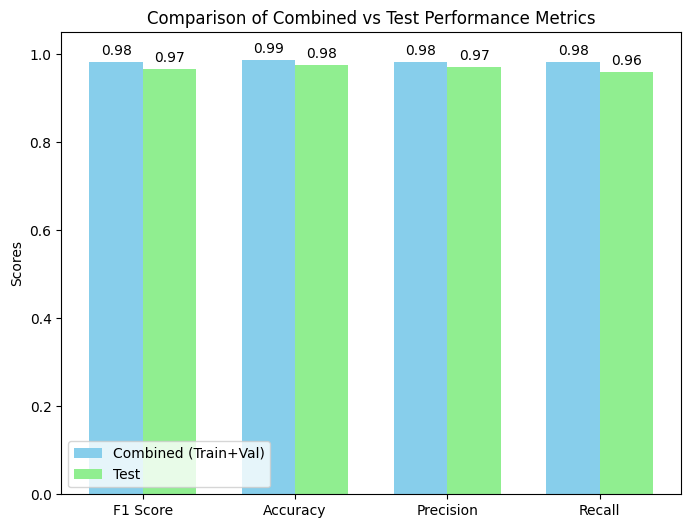

In [9]:
# ---------------------------------------
# Evaluation and Visualization Cell
# ---------------------------------------
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# --- Evaluate on Combined (Train+Val) Dataset ---
# Use train_embeddings as it contains the embeddings for the combined data.
combined_preds = clf.predict(train_embeddings)
print("Combined (Train+Val) Set Evaluation:")
print(classification_report(combined_labels, combined_preds))

f1_combined = f1_score(combined_labels, combined_preds, pos_label=1)
accuracy_combined = accuracy_score(combined_labels, combined_preds)
precision_combined = precision_score(combined_labels, combined_preds, pos_label=1)
recall_combined = recall_score(combined_labels, combined_preds, pos_label=1)

print("Combined Set Metrics:")
print("F1 Score for ads (label 1):", f1_combined)
print("Accuracy:", accuracy_combined)
print("Precision for ads (label 1):", precision_combined)
print("Recall for ads (label 1):", recall_combined)

# --- Evaluate on Test Set ---
test_preds = clf.predict(test_embeddings)
print("\nTest Set Evaluation:")
print(classification_report(test_labels, test_preds))

f1_test = f1_score(test_labels, test_preds, pos_label=1)
accuracy_test = accuracy_score(test_labels, test_preds)
precision_test = precision_score(test_labels, test_preds, pos_label=1)
recall_test = recall_score(test_labels, test_preds, pos_label=1)

print("Test Set Metrics:")
print("F1 Score for ads (label 1):", f1_test)
print("Accuracy:", accuracy_test)
print("Precision for ads (label 1):", precision_test)
print("Recall for ads (label 1):", recall_test)

# --- Visualization ---
metrics = ['F1 Score', 'Accuracy', 'Precision', 'Recall']
combined_values = [f1_combined, accuracy_combined, precision_combined, recall_combined]
test_values = [f1_test, accuracy_test, precision_test, recall_test]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, combined_values, width, label='Combined (Train+Val)', color='skyblue')
rects2 = ax.bar(x + width/2, test_values, width, label='Test', color='lightgreen')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Combined vs Test Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

ax.set_ylim(0, 1.05)
plt.show()


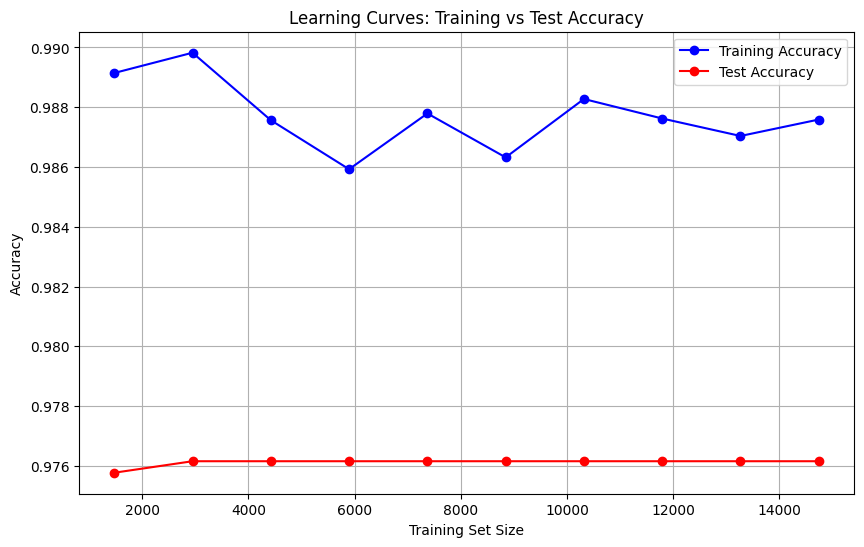

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define a range of training set fractions (from 10% to 100% of the combined training data)
fractions = np.linspace(0.1, 1.0, 10)
n_total = len(combined_labels)  # total number of examples in combined data

# Lists to store accuracy values
train_accuracies = []
test_accuracies = []
train_sizes = []

# For reproducibility
rng = np.random.default_rng(seed=42)

for frac in fractions:
    n_samples = int(frac * n_total)
    train_sizes.append(n_samples)
    
    # Randomly select a subset of the combined training data
    indices = rng.choice(n_total, size=n_samples, replace=False)
    X_train_subset = train_embeddings[indices]
    y_train_subset = np.array(combined_labels)[indices]
    
    # Train a new logistic regression classifier on the subset
    clf_subset = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    clf_subset.fit(X_train_subset, y_train_subset)
    
    # Evaluate on the training subset
    train_pred_subset = clf_subset.predict(X_train_subset)
    train_acc = accuracy_score(y_train_subset, train_pred_subset)
    train_accuracies.append(train_acc)
    
    # Evaluate on the fixed test set
    test_pred = clf_subset.predict(test_embeddings)
    test_acc = accuracy_score(test_labels, test_pred)
    test_accuracies.append(test_acc)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_accuracies, marker='o', linestyle='-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, test_accuracies, marker='o', linestyle='-', color='red', label='Test Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves: Training vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()
